In [10]:
from __future__ import print_function
import torch

In [69]:

def load_mnist_data():
    ## MNIST data
    from pathlib import Path
    import requests

    DATA_PATH = Path("../../data")
    PATH = DATA_PATH / "mnist"

    PATH.mkdir(parents=True, exist_ok=True)

    URL = "http://deeplearning.net/data/mnist/"
    FILENAME = "mnist.pkl.gz"

    if not (PATH / FILENAME).exists():
            content = requests.get(URL + FILENAME).content
            (PATH / FILENAME).open("wb").write(content)

    import pickle
    import gzip

    with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
            ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")
    return x_train, y_train, x_valid, y_valid

x_train, y_train, x_val, y_val = load_mnist_data()
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(50000, 784) (50000,) (10000, 784) (10000,)


torch.Size([50000, 784])


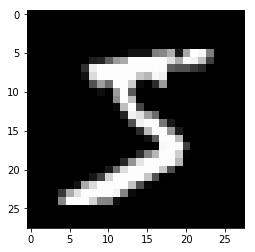

In [197]:
from matplotlib import pyplot as plt
import numpy as np

print(x_train.shape)

plt.imshow(x_train[0].reshape((28, 28)), cmap="gray")
plt.show()

In [208]:
import torch

x_train, y_train, x_val, y_val = map(
    torch.tensor, (x_train, y_train, x_val, y_val)
)

## Chack dimension
n, c = x_train.shape
print(x_train.shape)

## Check data
print(x_train)
print(y_train)
print(y_train.min(), y_train.max())
print(x_val)
print(y_val)
print(y_val.min(), y_val.max())

torch.Size([50000, 784])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([5, 0, 4,  ..., 8, 4, 8])
tensor(0) tensor(9)
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([3, 8, 6,  ..., 5, 6, 8])
tensor(0) tensor(9)


C:\Users\kmc55\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [209]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [210]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

In [211]:
def nll(pred, gt):
    return -pred[range(gt.shape[0]), gt].mean()

loss_func = nll

In [212]:
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x

preds = model(xb)  # predictions
preds[0], preds.shape
print(preds[0], preds.shape)

yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor([-2.0567, -2.2005, -2.4571, -2.7921, -1.7249, -2.4228, -2.1042, -2.3001,
        -2.8629, -2.6848], grad_fn=<SelectBackward>) torch.Size([64, 10])
tensor(2.4394, grad_fn=<NegBackward>)


In [213]:
xv = x_val[0:bs]

preds = model(xv)  # predictions
preds[0], preds.shape
print(preds[0], preds.shape)

yv = y_val[0:bs]
print(loss_func(preds, yv))


tensor([-2.3359, -2.3538, -2.7195, -2.3743, -1.9226, -2.3900, -1.8722, -2.3636,
        -2.6175, -2.4015], grad_fn=<SelectBackward>) torch.Size([64, 10])
tensor(2.4113, grad_fn=<NegBackward>)


In [214]:
print(yv)

tensor([3, 8, 6, 9, 6, 4, 5, 3, 8, 4, 5, 2, 3, 8, 4, 8, 1, 5, 0, 5, 9, 7, 4, 1,
        0, 3, 0, 6, 2, 9, 9, 4, 1, 3, 6, 8, 0, 7, 7, 6, 8, 9, 0, 3, 8, 3, 7, 7,
        8, 4, 4, 1, 2, 9, 8, 1, 1, 0, 6, 6, 5, 0, 1, 1])


In [215]:
print(yb)

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0])


In [216]:
def accuracy(out, y):
    preds = torch.argmax(out, dim=1)
    return (preds == y).float().mean()

In [217]:
print(accuracy(preds, yb))

tensor(0.0938)


In [219]:
from IPython.core.debugger import set_trace

lr = 0.5  # learning rate
epochs = 5  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        
        ## Feed foward
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        ## Backpropagation
        loss.backward()
        
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()
        
    print(loss_func(model(xb), yb), accuracy(model(xb), yb))
    print(loss_func(model(xv), yv), accuracy(model(xv), yv))

tensor(0.0596, grad_fn=<NegBackward>) tensor(1.)
tensor(0.2617, grad_fn=<NegBackward>) tensor(0.9375)
tensor(0.0580, grad_fn=<NegBackward>) tensor(1.)
tensor(0.2613, grad_fn=<NegBackward>) tensor(0.9375)
tensor(0.0568, grad_fn=<NegBackward>) tensor(1.)
tensor(0.2611, grad_fn=<NegBackward>) tensor(0.9375)
tensor(0.0558, grad_fn=<NegBackward>) tensor(1.)
tensor(0.2612, grad_fn=<NegBackward>) tensor(0.9375)
tensor(0.0550, grad_fn=<NegBackward>) tensor(1.)
tensor(0.2614, grad_fn=<NegBackward>) tensor(0.9375)


In [220]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias



In [222]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))
print(loss_func(model(xv), yv), accuracy(model(xv), yv))

tensor(0.0550, grad_fn=<NllLossBackward>) tensor(1.)
tensor(0.2614, grad_fn=<NllLossBackward>) tensor(0.9375)


In [263]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

model = Mnist_Logistic()

In [264]:
print(loss_func(model(xb), yb))

tensor(2.3178, grad_fn=<NllLossBackward>)


In [265]:
with torch.no_grad():
    weights -= weights.grad * lr
    bias -= bias.grad * lr
    weights.grad.zero_()
    bias.grad.zero_()

In [267]:
loss = loss_func(model(xb), yb)
loss.backward()

with torch.no_grad():
    for p in model.parameters(): 
        print(p)
        p -= p.grad * lr
    model.zero_grad()

Parameter containing:
tensor([[ 0.0392, -0.0555, -0.0083,  ...,  0.0028,  0.0009, -0.0640],
        [ 0.0100, -0.0537, -0.0411,  ..., -0.0050, -0.0390, -0.0024],
        [-0.0399,  0.0621,  0.0740,  ..., -0.0078, -0.0377,  0.0136],
        ...,
        [ 0.0337,  0.0638, -0.0082,  ...,  0.0518, -0.0146,  0.0063],
        [-0.1005, -0.0047, -0.0258,  ..., -0.0182, -0.0121, -0.0108],
        [ 0.0705, -0.0244,  0.0141,  ..., -0.0522, -0.0135, -0.0297]],
       requires_grad=True)
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)


In [253]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

In [241]:
print(loss_func(model(xb), yb))

tensor(0.0622, grad_fn=<NllLossBackward>)


In [242]:
print(loss_func(model(xv), yv))

tensor(0.2607, grad_fn=<NllLossBackward>)
